# What characterises a patient who is predicted to have high variation in thrombolysis use across different hospitals?

We categorise patients based on the proportion of hospitals that are predicted to give them thrombolysis

* Non-thrombolysed: 70% or more units would not thrombolyse this patient
* Contentious: 30-70% of units would thrombolyse this patient
* Thrombolysed: 70% or more units would thrombolyse this patient

We provide descriptive statistics for those three groups. We then go onto to train a Random Forest model to distinguish *Contentious* from *Thrombolysed*, and examine feture importance and Shapley values to identify features most predictive of the distinction between those two categories.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc

from scipy.spatial.distance import hamming
from seriate import seriate

import shap

## Load data

In [3]:
train = pd.read_csv('./../data/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv('./../data/10k_training_test/cohort_10000_test.csv')
# Combine train and test data
data = pd.concat([train, test], axis=0)

## Load pre-trained models

These models are Random Forest models trained for each hopsital, calibrated so that each hopsital has a unique threshold for classification, that gives the expected thrombolysis use at that hopsital. 

In [4]:
with open ('./models/trained_hospital_models_for _cohort.pkl', 'rb') as f:
    
    hospital2model = pkl.load(f)

## Pass 10K test cohort through all hospital models

In [5]:
cohort = test

hospitals = list(set(data['StrokeTeam'].values))

cohort_results = pd.DataFrame(columns = hospitals, index = cohort.index.values)
cohort_results_prob = pd.DataFrame(columns = hospitals, index = cohort.index.values)
    
for hospital_train in hospitals:
   
    test_patients = cohort
    
    y = test_patients['S2Thrombolysis']
    X = test_patients.drop(['StrokeTeam','S2Thrombolysis'], axis=1)

    model = hospital2model[hospital_train][0]
    threshold = hospital2model[hospital_train][1]
    #threshold=0.5

    y_prob = model.predict_proba(X)[:,1]
    
    y_pred = [1 if p>=threshold else 0 for p in y_prob]
    
    new_column = pd.Series(y_pred, name=hospital_train, index=test_patients.index.values)
        
    cohort_results.update(new_column)
    
    new_column_prob = pd.Series(y_prob, name=hospital_train, index=test_patients.index.values)
        
    cohort_results_prob.update(new_column_prob)

## Identify contentious patients

We categorise patients based on the proportion of hospitals that are predicted to give them thrombolysis

* Non-thrombolysed: 70% or more units would not thrombolyse this patient
* Contentious: 30-70% of units would thrombolyse this patient
* Thrombolysed: 70% or more units would thrombolyse this patient

In [6]:
# Get proportion of hopsitals thrombolysing, or agreeing
results = cohort_results 
results['sum'] = results.sum(axis=1)
results['percent'] = results['sum']/len(hospitals)
results['percent_agree'] = [max(p, 1-p) for p in results['percent']]

# Extract cohort patients that only 30-70% of hospitals would thrombolyse
contentious = results[results['percent_agree']<=0.7]
contentious = contentious.drop(['sum', 'percent', 'percent_agree'], axis=1)

## Characterise contentious patients

### Onset to arrival

In [7]:
content = (cohort.loc[contentious.index]['S1OnsetToArrival_min'].mean(),\
           cohort.loc[contentious.index]['S1OnsetToArrival_min'].std())
throm = (cohort.loc[cohort_results['percent']>0.7]['S1OnsetToArrival_min'].mean(),\
         cohort.loc[cohort_results['percent']>0.7]['S1OnsetToArrival_min'].std())
no_throm = (cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetToArrival_min'].mean(),\
         cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetToArrival_min'].std())

print(f'Contentious: Mean = {content[0]:.0f}, StdDev = {content[1]:.0f}')
print(f'Thrombolysed: Mean = {throm[0]:.0f}, StdDev = {throm[1]:.0f}')
print(f'Not Thrombolysed: Mean = {no_throm[0]:.0f}, StdDev = {no_throm[1]:.0f}')

Contentious: Mean = 102, StdDev = 49
Thrombolysed: Mean = 88, StdDev = 40
Not Thrombolysed: Mean = 124, StdDev = 55


### NIHSS

In [8]:
content = (cohort.loc[contentious.index]['S2NihssArrival'].mean(),\
           cohort.loc[contentious.index]['S2NihssArrival'].std())
throm = (cohort.loc[cohort_results['percent']>0.7]['S2NihssArrival'].mean(),\
         cohort.loc[cohort_results['percent']>0.7]['S2NihssArrival'].std())
no_throm = (cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2NihssArrival'].mean(),\
         cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2NihssArrival'].std())

print(f'Contentious: Mean = {content[0]:.1f}, StdDev = {content[1]:.1f}')
print(f'Thrombolysed: Mean = {throm[0]:.1f}, StdDev = {throm[1]:.1f}')
print(f'Not Thrombolysed: Mean = {no_throm[0]:.1f}, StdDev = {no_throm[1]:.1f}')

Contentious: Mean = 11.8, StdDev = 7.9
Thrombolysed: Mean = 13.3, StdDev = 6.5
Not Thrombolysed: Mean = 5.9, StdDev = 6.8


#### NIHSS components

In [9]:
nihss = ['Loc', 'LocQuestions', 'LocCommands',
       'BestGaze', 'Visual', 'FacialPalsy', 'MotorArmLeft', 'MotorArmRight',
       'MotorLegLeft', 'MotorLegRight', 'LimbAtaxia', 'Sensory',
       'BestLanguage', 'Dysarthria', 'ExtinctionInattention']
       #'S2NihssArrival']

In [10]:
content = [cohort.loc[contentious.index][n].mean() for n in nihss]
content_err_min = [cohort.loc[contentious.index][n].quantile(0.25) for n in nihss]
content_err_max = [cohort.loc[contentious.index][n].quantile(0.75) for n in nihss]

content_err = [content_err_min, content_err_max]

throm = [cohort.loc[cohort_results['percent']>0.7][n].mean() for n in nihss]
throm_err_min = [cohort.loc[cohort_results['percent']>0.7][n].quantile(0.25) for n in nihss]
throm_err_max = [cohort.loc[cohort_results['percent']>0.7][n].quantile(0.75) for n in nihss]

throm_err = [throm_err_min, throm_err_max]

no_throm = [cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2Thrombolysis']==1][n].mean() for n in nihss]
no_throm_err_min = [cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2Thrombolysis']==1][n].quantile(0.25) for n in nihss]
no_throm_err_max = [cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2Thrombolysis']==1][n].quantile(0.75) for n in nihss]

no_throm_err = [no_throm_err_min, no_throm_err_max]

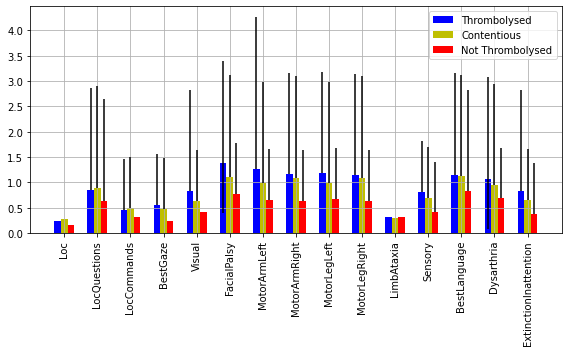

In [11]:
X = np.arange(len(nihss))
fig,ax = plt.subplots(figsize=(8,5))

ax.bar(X - 0.2, throm, color = 'b', width = 0.2, label='Thrombolysed', yerr= throm_err)
#ax.bar(X + 0.1, throm, color = 'r', width = 0.2, label = 'True Thrombolysed')
#ax.bar(X - 0.1, all_, color = 'g', width = 0.2, label = 'Cohort')
ax.bar(X, content, color = 'y', width = 0.2,  label = 'Contentious',yerr= content_err)
ax.bar(X + 0.2, no_throm, color = 'r', width = 0.2, label = 'Not Thrombolysed',yerr= no_throm_err)
ax.set_xticks(X)
ax.set_xticklabels(nihss,  rotation=90)
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.savefig('./output/contentious_nihss.jpg', dpi=300)
plt.show()

Histograms of NIHSS

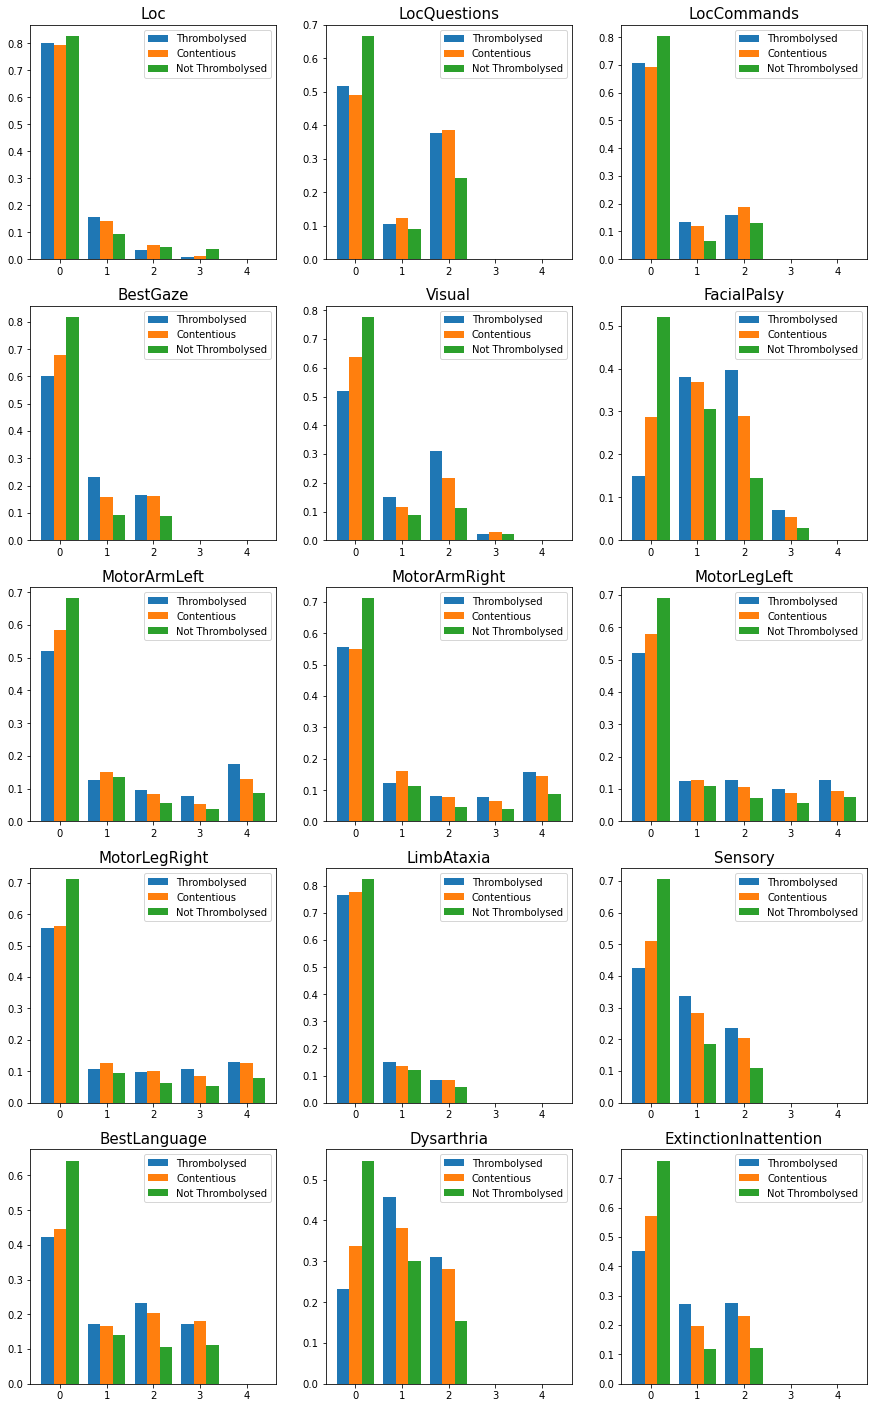

In [12]:
fig = plt.figure(figsize = (15,25))

bins = np.arange(6)
names = ['Thrombolysed','Contentious','Not Thrombolysed']

hist_list = []

for i in range(len(nihss)):
    
    ax = fig.add_subplot(5,3,i+1)
    
    content = cohort.loc[contentious.index][nihss[i]]
    throm = cohort.loc[cohort_results['percent']>0.7][nihss[i]]
    nothrom = cohort.loc[cohort_results['percent']<0.3][nihss[i]]
    
    dta = [throm,content,nothrom]
    x, bins, _ = ax.hist(dta,  histtype='bar', density=True, label=names, bins=bins, align='left')
    #ax.hist(nothrom,bins=bins, label = f'Not Thrombolysed', histtype='bar',stacked=True)
    #ax.hist(throm, bins=bins,label = f'Thrombolysed', histtype='bar',stacked=True)
    #ax.hist(content, bins=bins, label = f'Contentious', histtype='bar',stacked=True)
    hist_list.append(x)
    feat = nihss[i]
    
    plt.title(feat, fontsize=15)
    
    ax.legend(loc='best')

fig.savefig('./output/contentious_nihss_hist.jpg', dpi=300)

Use Kolmogorov-Smirnov test to check for differenecnes in distrubtions.

In [13]:
from scipy.stats import kstest

for i in range(len(nihss)):
    
    content = cohort.loc[contentious.index][nihss[i]]
    throm = cohort.loc[cohort_results['percent']>0.7][nihss[i]]
    nothrom = cohort.loc[cohort_results['percent']<0.3][nihss[i]]
    
    print(nihss[i], '\n')
    
    print('Throm vs contentious')
    
    D,p = kstest(throm,content)
    print(f'D = {round(D,2)}, p = {round(p,3)}')
    
    D,p = kstest(nothrom,content)
    print('NoThrom vs contentious')
    print(f'D = {round(D,2)}, p = {round(p,3)}', '\n')

Loc 

Throm vs contentious
D = 0.02, p = 0.747
NoThrom vs contentious
D = 0.03, p = 0.136 

LocQuestions 

Throm vs contentious
D = 0.03, p = 0.542
NoThrom vs contentious
D = 0.18, p = 0.0 

LocCommands 

Throm vs contentious
D = 0.03, p = 0.552
NoThrom vs contentious
D = 0.11, p = 0.0 

BestGaze 

Throm vs contentious
D = 0.07, p = 0.0
NoThrom vs contentious
D = 0.14, p = 0.0 

Visual 

Throm vs contentious
D = 0.12, p = 0.0
NoThrom vs contentious
D = 0.14, p = 0.0 

FacialPalsy 

Throm vs contentious
D = 0.14, p = 0.0
NoThrom vs contentious
D = 0.23, p = 0.0 

MotorArmLeft 

Throm vs contentious
D = 0.09, p = 0.0
NoThrom vs contentious
D = 0.1, p = 0.0 

MotorArmRight 

Throm vs contentious
D = 0.03, p = 0.453
NoThrom vs contentious
D = 0.16, p = 0.0 

MotorLegLeft 

Throm vs contentious
D = 0.06, p = 0.003
NoThrom vs contentious
D = 0.11, p = 0.0 

MotorLegRight 

Throm vs contentious
D = 0.02, p = 0.71
NoThrom vs contentious
D = 0.15, p = 0.0 

LimbAtaxia 

Throm vs contentious
D =

#### NIHSS binned by value

In [14]:
content = cohort.loc[cohort_results['percent_agree']<=0.7]#['S2NihssArrival']
throm = cohort.loc[cohort_results['percent']>0.7]#['S2NihssArrival']
no_throm = cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]#['S2NihssArrival']

bars = []
numbers = []
numbers_stratified = []
for i in range(40):
    
    n_content = len(content.loc[content['S2NihssArrival']==i])
    n_throm = len(throm.loc[throm['S2NihssArrival']==i])
    n_nothrom = len(no_throm.loc[no_throm['S2NihssArrival']==i])
    
    all_=np.array([n_content,n_throm,n_nothrom])
    
    numbers_stratified.append(all_)
    
    numbers.append(np.sum(all_))
    
    bars.append(all_/sum(all_))
    
c,t,nt = zip(*bars)

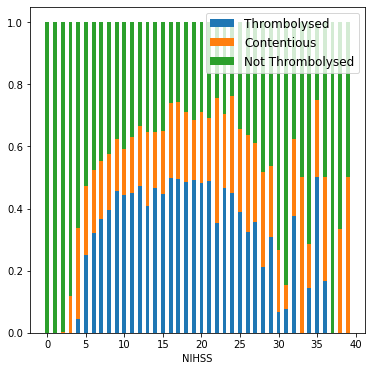

In [15]:
fig,ax = plt.subplots(figsize=(6,6))

locs = np.arange(40)

ax.bar(locs, t, width = 0.5, label='Thrombolysed')
ax.bar(locs, c, width=0.5, bottom=t, label='Contentious')
ax.bar(locs, nt, width = 0.5, bottom = np.vstack((t,c)).sum(axis=0), label='Not Thrombolysed')

plt.legend(loc='best', fontsize=12)
#plt.ylim(0,1.2)
plt.xlabel('NIHSS')
plt.savefig('./output/nihss_proportions_1.jpg', dpi=300)
plt.show()

Add errors using bernoulli distribution

$$\sigma = \sqrt{\frac{pq}{n}}$$

- p = proportion of NIHSS value agreed

- q = proportion of NIHSS value contentious

- n = number of people with NIHSS value

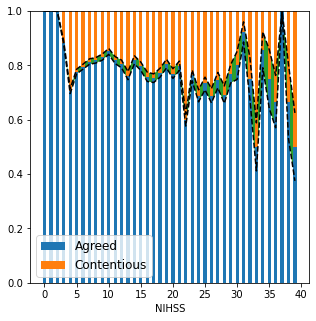

In [16]:
fig,ax = plt.subplots(figsize=(5,5))

locs = np.arange(40)

a = np.vstack((t,nt)).sum(axis=0)

ax.bar(locs, a, width = 0.5, label='Agreed')
ax.bar(locs, c, width=0.5, bottom=a, label='Contentious')


err = np.sqrt(a*c/np.array(numbers))

#ax.bar(locs, err, width = 0.5, bottom = a-err/2)

ax.plot(locs, a-err/2, 'k--')
ax.plot(locs, a+err/2, 'k--')

plt.fill_between(locs, a-err/2, a+err/2, 'g', alpha=1)

plt.legend(loc='best', fontsize=12)
#plt.ylim(0,1.2)
plt.xlabel('NIHSS')
plt.savefig('./output/nihss_proportions_2.jpg', dpi=300)
plt.show()

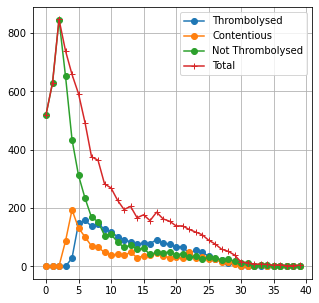

In [17]:
fig,ax = plt.subplots(figsize=(5,5))

n_c,n_t,n_nt = zip(*numbers_stratified)

plt.plot(n_t, 'o-', label = 'Thrombolysed')
plt.plot(n_c, 'o-', label = 'Contentious')
plt.plot(n_nt, 'o-', label = 'Not Thrombolysed')
plt.plot(numbers, '+-', label = 'Total')

plt.legend(loc='best')
plt.grid()
plt.savefig('./output/nihss_numbers.jpg', dpi=300)
plt.show()

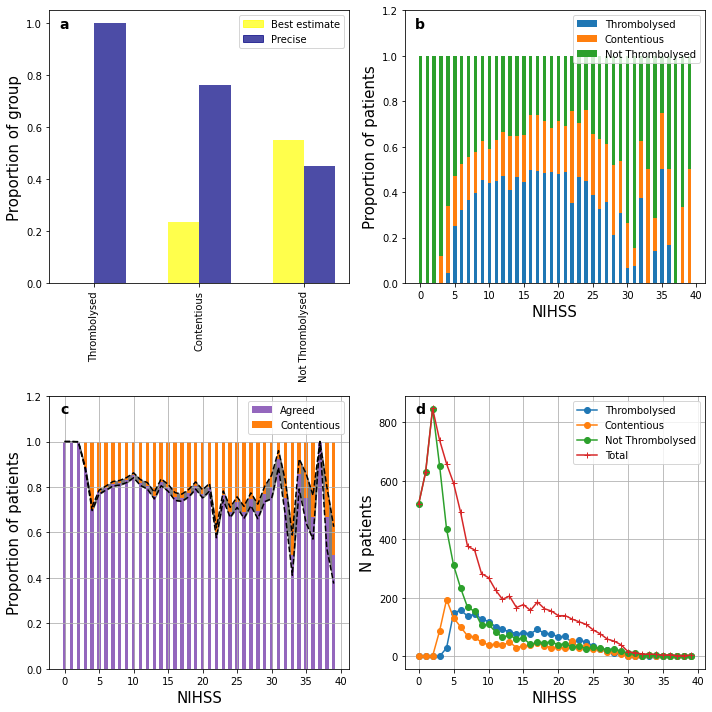

In [18]:
fig = plt.figure(figsize=(10,10))

ax0 = fig.add_subplot(2,2,1)

content = 2*cohort.loc[cohort_results['percent_agree']<=0.7]['S1OnsetTimeType_Precise'] + cohort.loc[cohort_results['percent_agree']<=0.7]['S1OnsetTimeType_Best estimate']
throm = 2*cohort.loc[cohort_results['percent']>0.7]['S1OnsetTimeType_Precise'] + cohort.loc[cohort_results['percent']>0.7]['S1OnsetTimeType_Best estimate']
no_throm = 2*cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetTimeType_Precise']\
+ cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetTimeType_Best estimate']

throm_h,edges = np.histogram(throm, bins = [1,2,3], density=True)
nothrom_h,edges = np.histogram(no_throm, bins = [1,2,3], density=True)
content_h,edges = np.histogram(content, bins = [1,2,3], density=True)

ax0.bar([0.85,1.15],throm_h, width=0.3, color = ['yellow','navy'], alpha=0.7)

ax0.bar([1.85,2.15],content_h, width=0.3, color = ['yellow','navy'], alpha=0.7)

ax0.bar([2.85,3.15],nothrom_h, width=0.3, color = ['yellow','navy'], alpha=0.7)

ax0.set_xticks([1,2,3])

ax0.set_xticklabels(names, rotation=90)

ax0.text(0.05, 0.95, 'a', horizontalalignment='center', weight='bold', fontsize=14,
      verticalalignment='center', transform=ax0.transAxes)

plt.ylabel('Proportion of group', fontsize=15)

colors = {'Best estimate':'yellow', 'Precise':'navy'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label], alpha=0.7) for label in labels]
plt.legend(handles, labels)

ax = fig.add_subplot(2,2,2)

locs = np.arange(40)

ax.bar(locs, t, width = 0.5, label='Thrombolysed')
ax.bar(locs, c, width=0.5, bottom=t, label='Contentious')
ax.bar(locs, nt, width = 0.5, bottom = np.vstack((t,c)).sum(axis=0), label='Not Thrombolysed')

plt.xlabel('NIHSS', fontsize=15)
plt.ylabel('Proportion of patients', fontsize=15 )
plt.legend(loc='best')
plt.ylim(0,1.2)

ax.text(0.05, 0.95, 'b', horizontalalignment='center', weight='bold', fontsize=14,
      verticalalignment='center', transform=ax.transAxes)

ax2 = fig.add_subplot(2,2,3)


locs = np.arange(40)

a = np.vstack((t,nt)).sum(axis=0)

ax2.bar(locs, a, width = 0.5, color = 'tab:purple', label='Agreed')
ax2.bar(locs, c, width=0.5, bottom=a, color = 'tab:orange', label='Contentious')
err = np.sqrt(a*c/np.array(numbers))

#ax.bar(locs, err, width = 0.5, bottom = a-err/2)

ax2.plot(locs, a-err/2, 'k--')
ax2.plot(locs, a+err/2, 'k--')

plt.fill_between(locs, a-err/2, a+err/2, color = 'tab:gray', alpha=1)



plt.legend(loc='best')
plt.ylim(0,1.2)
plt.xlabel('NIHSS', fontsize=15)
plt.ylabel('Proportion of patients', fontsize=15 )
ax2.grid()
ax2.text(0.05, 0.95, 'c', horizontalalignment='center', weight='bold', fontsize=14,
      verticalalignment='center', transform=ax2.transAxes)

ax1 = fig.add_subplot(2,2,4)

n_c,n_t,n_nt = zip(*numbers_stratified)

plt.plot(n_t, 'o-', label = 'Thrombolysed')
plt.plot(n_c, 'o-', label = 'Contentious')
plt.plot(n_nt, 'o-', label = 'Not Thrombolysed')
plt.plot(numbers, '+-', label = 'Total')

plt.legend(loc='best')
plt.xlabel('NIHSS', fontsize=15)
plt.ylabel('N patients', fontsize=15 )
plt.grid()

ax1.text(0.05, 0.95, 'd', horizontalalignment='center', weight='bold', fontsize=14,
      verticalalignment='center', transform=ax1.transAxes)

plt.tight_layout()

plt.savefig('./output/nihss_4.jpg', dpi=300)

plt.show()

### Rankin before stroke

In [19]:
content = (cohort.loc[contentious.index]['S2RankinBeforeStroke'].mean(), \
           cohort.loc[contentious.index]['S2RankinBeforeStroke'].std())
throm = (cohort.loc[cohort_results['percent']>0.7]['S2RankinBeforeStroke'].mean(),\
         cohort.loc[cohort_results['percent']>0.7]['S2RankinBeforeStroke'].std())
no_throm = (cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2RankinBeforeStroke'].mean(),\
         cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2RankinBeforeStroke'].std())

print(f'Contentious: Mean = {content[0]:.2f}, StdDev = {content[1]:.2f}')
print(f'Thrombolysed: Mean = {throm[0]:.2f}, StdDev = {throm[1]:.2f}')
print(f'Not Thrombolysed: Mean = {no_throm[0]:.2f}, StdDev = {no_throm[1]:.2f}')

Contentious: Mean = 1.12, StdDev = 1.44
Thrombolysed: Mean = 0.58, StdDev = 1.05
Not Thrombolysed: Mean = 1.21, StdDev = 1.49


#### Rankin distributions

In [20]:
content = cohort.loc[cohort_results['percent_agree']<=0.7]#['S2NihssArrival']
throm = cohort.loc[cohort_results['percent']>0.7]#['S2NihssArrival']
no_throm = cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]#['S2NihssArrival']

bars = []
numbers = []
numbers_stratified = []
for i in range(6):
    
    n_content = len(content.loc[content['S2RankinBeforeStroke']==i])
    n_throm = len(throm.loc[throm['S2RankinBeforeStroke']==i])
    n_nothrom = len(no_throm.loc[no_throm['S2RankinBeforeStroke']==i])
    
    all_=np.array([n_content,n_throm,n_nothrom])
    
    numbers_stratified.append(all_)
    
    numbers.append(np.sum(all_))
    
    bars.append(all_/sum(all_))
    
c,t,nt = zip(*bars)

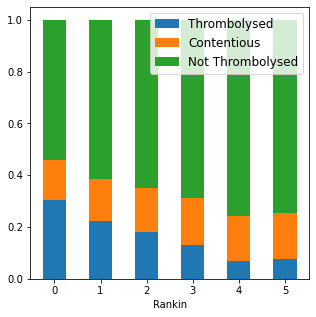

In [21]:
fig,ax = plt.subplots(figsize=(5,5))

locs = np.arange(6)

ax.bar(locs, t, width = 0.5, label='Thrombolysed')
ax.bar(locs, c, width=0.5, bottom=t, label='Contentious')
ax.bar(locs, nt, width = 0.5, bottom = np.vstack((t,c)).sum(axis=0), label='Not Thrombolysed')

plt.legend(loc='best', fontsize=12)
#plt.ylim(0,1.2)
plt.xlabel('Rankin')
plt.savefig('./output/rankin_proportions_1.jpg', dpi=300)
plt.show()

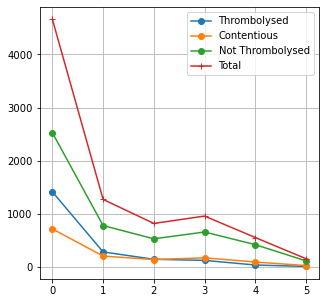

In [22]:
fig,ax = plt.subplots(figsize=(5,5))

n_c,n_t,n_nt = zip(*numbers_stratified)

plt.plot(n_t, 'o-', label = 'Thrombolysed')
plt.plot(n_c, 'o-', label = 'Contentious')
plt.plot(n_nt, 'o-', label = 'Not Thrombolysed')
plt.plot(numbers, '+-', label = 'Total')

plt.legend(loc='best')
plt.grid()
plt.savefig('./output/rankin_numbers.jpg', dpi=300)
plt.show()

### Age

In [23]:
content = (cohort.loc[contentious.index]['S1AgeOnArrival'].mean(), \
           cohort.loc[contentious.index]['S1AgeOnArrival'].std())
throm = (cohort.loc[cohort_results.sum(axis=1)>92]['S1AgeOnArrival'].mean(),\
         cohort.loc[cohort_results.sum(axis=1)>92]['S1AgeOnArrival'].std())
no_throm = (cohort.loc[cohort_results.sum(axis=1)<40].loc[cohort['S2StrokeType_Infarction']==1]['S1AgeOnArrival'].mean(),\
         cohort.loc[cohort_results.sum(axis=1)<40].loc[cohort['S2StrokeType_Infarction']==1]['S1AgeOnArrival'].std())

print(f'Contentious: Mean = {content[0]:.1f}, StdDev = {content[1]:.1f}')
print(f'Thrombolysed: Mean = {throm[0]:.1f}, StdDev = {throm[1]:.1f}')
print(f'Not Thrombolysed: Mean = {no_throm[0]:.1f}, StdDev = {no_throm[1]:.1f}')

Contentious: Mean = 75.1, StdDev = 13.9
Thrombolysed: Mean = 73.3, StdDev = 13.7
Not Thrombolysed: Mean = 76.2, StdDev = 14.1


### Scan time 

In [24]:
content = (cohort.loc[contentious.index]['S2BrainImagingTime_min'].mean(), \
           cohort.loc[contentious.index]['S2BrainImagingTime_min'].std())
throm = (cohort.loc[cohort_results['percent']>0.7]['S2BrainImagingTime_min'].mean(),\
         cohort.loc[cohort_results['percent']>0.7]['S2BrainImagingTime_min'].std())
no_throm = (cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2BrainImagingTime_min'].mean(),\
         cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S2BrainImagingTime_min'].std())

print(f'Contentious: Mean = {content[0]:.1f}, StdDev = {content[1]:.1f}')
print(f'Thrombolysed: Mean = {throm[0]:.1f}, StdDev = {throm[1]:.1f}')
print(f'Not Thrombolysed: Mean = {no_throm[0]:.1f}, StdDev = {no_throm[1]:.1f}')

Contentious: Mean = 26.3, StdDev = 22.8
Thrombolysed: Mean = 18.8, StdDev = 12.2
Not Thrombolysed: Mean = 153.0, StdDev = 901.6


### Onset known type

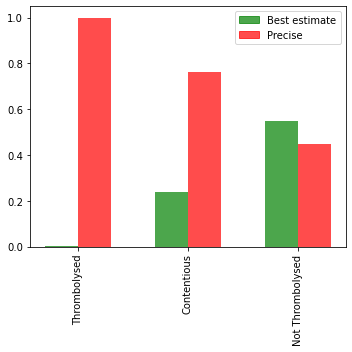

In [25]:
content = 2*cohort.loc[cohort_results['percent_agree']<=0.7]['S1OnsetTimeType_Precise'] + cohort.loc[cohort_results['percent_agree']<=0.7]['S1OnsetTimeType_Best estimate']
throm = 2*cohort.loc[cohort_results['percent']>0.7]['S1OnsetTimeType_Precise'] + cohort.loc[cohort_results['percent']>0.7]['S1OnsetTimeType_Best estimate']
no_throm = 2*cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetTimeType_Precise']\
+ cohort.loc[cohort_results['percent']<0.3].loc[cohort['S2StrokeType_Infarction']==1]['S1OnsetTimeType_Best estimate']

#throm, content, no throm on x axis
fig, ax = plt.subplots(figsize=(5,5))

throm_h,edges = np.histogram(throm, bins = [1,2,3], density=True)
nothrom_h,edges = np.histogram(no_throm, bins = [1,2,3], density=True)
content_h,edges = np.histogram(content, bins = [1,2,3], density=True)

ax.bar([0.85,1.15],throm_h, width=0.3, color = ['g','r'], alpha=0.7)

ax.bar([1.85,2.15],content_h, width=0.3, color = ['g','r'], alpha=0.7)

ax.bar([2.85,3.15],nothrom_h, width=0.3, color = ['g','r'], alpha=0.7)

ax.set_xticks([1,2,3])

ax.set_xticklabels(names, rotation=90)

colors = {'Best estimate':'g', 'Precise':'r'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label], alpha=0.7) for label in labels]
plt.legend(handles, labels)
plt.savefig('./output/onset_time_type_histogram.jpg', dpi=300)
plt.tight_layout()
plt.show()

## Predicting which patients will be contentious, or agreed thrombolyse/no-thrombolyse

We fit a Random Forest classifier to predict which patients will be in each category, and then can use feature importances and Shapley values to understand which features drive categorisation.

### Classify into groups

In [26]:
# Define the band considered contentious
width = 0.4 # Patients with 30% to 70% hopsitals thrombolysing will be consider contentious

T = cohort.loc[cohort_results['percent']>(0.5 + width/2)]
NT = cohort.loc[cohort_results['percent']<(0.5 - width/2)].loc[cohort['S2StrokeType_Infarction']==1]
C = cohort.loc[cohort_results['percent_agree']<=(0.5 + width/2)]

In [27]:
# Proportion in each group
t_count = len(T)
nt_count = len(NT)
c_count = len(C)
total = sum([t_count, nt_count, c_count])

prop_t = t_count / total
prop_nt = nt_count / total
prop_c = c_count / total

print(f'Prop agree thrombolyse: {prop_t:0.3f}')
print(f'Prop contentious: {prop_c:0.3f}')
print(f'Prop agree not thrombolyse: {prop_nt:0.3f}')

Prop agree thrombolyse: 0.240
Prop contentious: 0.162
Prop agree not thrombolyse: 0.598


### Accuracy measurement

In [28]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

### Define funtion to fit classification predictor model

In [29]:
from sklearn.model_selection import train_test_split

def classify_group(g1, g2):
    
    data = pd.concat([g1,g2])
    
    reduced = data.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    yvals = np.concatenate((np.ones(len(g1)),np.zeros(len(g2))))
    
    X_train, X_test, y_train, y_test = train_test_split(
    reduced.values, yvals, test_size=0.33, random_state=42)
    
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                    class_weight='balanced', random_state=0)
    
    forest.fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    
    y_prob = forest.predict_proba(X_test)[:,1]
    
    imp = forest.feature_importances_
    
    return forest, y_test, y_pred, y_prob, imp, reduced.columns.values

### Model that distinguishes agreed thrombolysed vs contentious

In [30]:
forest, y_test, y_pred, y_prob, imp, feat = classify_group(T,C)

In [31]:
accuracy = pd.Series(calculate_accuracy(y_test,y_pred))
accuracy

observed_positive_rate       0.612154
observed_negative_rate       0.387846
predicted_positive_rate      0.651475
predicted_negative_rate      0.348525
accuracy                     0.912422
precision                    0.902606
recall                       0.960584
f1                           0.930693
sensitivity                  0.960584
specificity                  0.836406
positive_likelihood          5.871738
negative_likelihood          0.047126
false_positive_rate          0.163594
false_negative_rate          0.039416
true_positive_rate           0.960584
true_negative_rate           0.836406
positive_predictive_value    0.902606
negative_predictive_value    0.930769
dtype: float64

### Show feature imporatances for contentious vs thrombolysed

In [32]:
features = pd.DataFrame()
features['feature'] = feat
features['importance'] = imp

features.sort_values(by = 'importance', ascending=False, inplace=True)

# Display top 20 features
features[:20]

,feature,importance
18,S2NihssArrival,0.104195
36,S1OnsetTimeType_Precise,0.085606
19,S2BrainImagingTime_min,0.077009
34,S1OnsetTimeType_Best estimate,0.066169
1,S1OnsetToArrival_min,0.051140
2,S2RankinBeforeStroke,0.049437
0,S1AgeOnArrival,0.030873
8,FacialPalsy,0.028570
7,Visual,0.020973
16,Dysarthria,0.018751


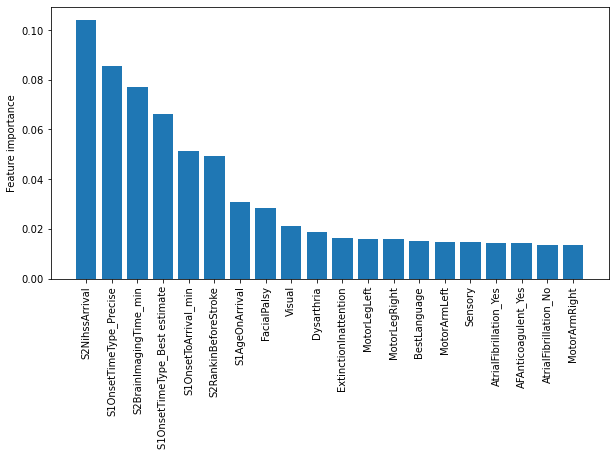

In [33]:
fig,ax = plt.subplots(figsize=(10,5))
n = 20
plt.bar(features['feature'][:n],features['importance'][:n])
ax.set_xticklabels(features['feature'][:n],  rotation=90)
ax.set_ylabel('Feature importance')
plt.savefig('./output/contentious_vs_thromb_feature_importance.jpg', dpi=300)
plt.show()

### Get improvement in ROC AUC with increasing number of features

In [34]:
def auc_feat(g1,g2,i):
    
    data = pd.concat([g1,g2])
    
    # Group 1 has label '1', and Group 2 has label '0'
    yvals = np.concatenate((np.ones(len(g1)),np.zeros(len(g2))))
    
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(
    data.values, yvals, test_size=0.33, random_state=42)
    
    for run in range(100):
        
        # Boot strap samples
        idx = np.random.randint(len(X_train), size=len(X_train))
        X_sampled = np.array([X_train[i] for i in idx])
        y_sampled = [y_train[i] for i in idx]

        if i==0:

            X_sampled = X_sampled.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)

        # Fit classifier
        forest = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                        class_weight='balanced', random_state=0)

        forest.fit(X_sampled,y_sampled)

        y_pred = forest.predict(X_test)

        y_prob = forest.predict_proba(X_test)[:,1]
        
        # Get ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Get ROC AUC
        results.append(round(auc(fpr, tpr),2))    
    
    return np.median(results), np.percentile(results,10), np.percentile(results,90)

In [35]:
auc_vals = []
feats = []

for i,f in enumerate(features['feature'].values[:30]):
    
    # Add features
    feats.append(f)
    
    if i==0:
    
        T_reduced = T[f] 
        C_reduced = C[f]
        
    else:
        
        T_reduced = T[feats]
        C_reduced = C[feats]
        
    # Get median, 10th percentile and 90th percentile AUC (from 50 runs)
    med,lo,hi = auc_feat(T_reduced,C_reduced,i)
    
    auc_vals.append([lo,med,hi])

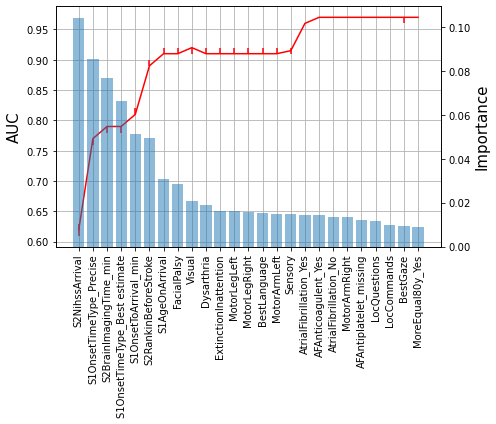

In [36]:
lo,med,hi = zip(*auc_vals)
lo_err = np.array(med)-np.array(lo)
hi_err = np.array(hi)-np.array(med)

fig = plt.figure(figsize=(7,6))

n = 25

ax2 = fig.add_subplot(1,1,1)


ax2.errorbar(np.arange(n), med[:n], yerr = [lo_err[:n],hi_err[:n]], fmt = '-r')

ax2.set_xticklabels(features['feature'][:n],  rotation=90)
#plt.fill_between(np.arange(1,100), lo, hi)

plt.ylabel('AUC', fontsize=15)

ax2.grid()

ax1 = ax2.twinx()

ax1.bar(features['feature'][:n],features['importance'][:n], alpha = 0.5)

ax1.set_xticklabels(features['feature'][:n],  rotation=90, fontsize=12)

#ax1.grid()
ax1.set_ylabel('Importance', fontsize=15) 

plt.tight_layout()

plt.savefig('./output/auc_features.jpg', dpi=300)

plt.show()

### Shap bee swarm plot

In [37]:
import shap

def classify_group_shap(g1, g2):
    
    data = pd.concat([g1,g2])
    
    reduced = data.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    yvals = np.concatenate((np.ones(len(g1)),np.zeros(len(g2))))
    
    X_train, X_test, y_train, y_test = train_test_split(
    reduced.values, yvals, test_size=0.33, random_state=42)
    
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                    class_weight='balanced', random_state=0)
    
    forest.fit(X_train,y_train)
    
    explainer = shap.TreeExplainer(forest, reduced)
    shap_values = explainer(reduced)
    
    return forest, X_test, shap_values

In [38]:
forest, X_test, shapObj = classify_group_shap(T,C)

100%|===================| 6749/6776 [02:18<00:00]        

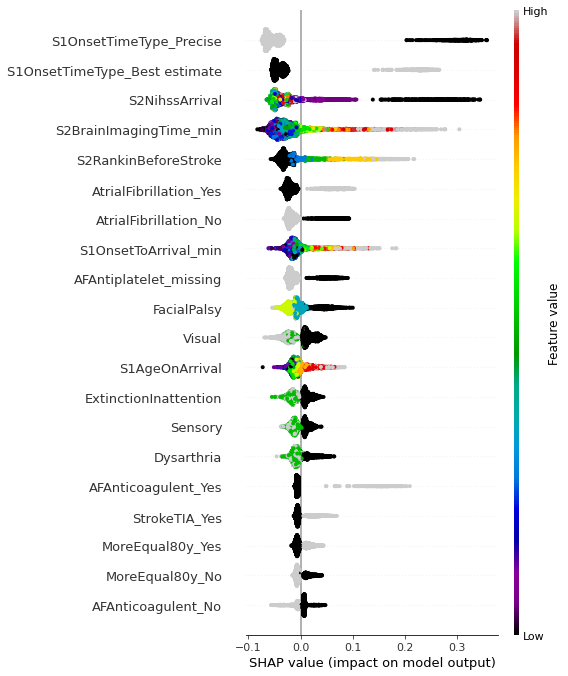

In [39]:
dta = pd.concat([T,C]).drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

#shap.plots.beeswarm(shap_values)

fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = np.take(shapObj.values, 0, axis=-1), features = dta.values,
                 feature_names = dta.columns.values, cmap = plt.get_cmap('nipy_spectral'), show=False)
plt.tight_layout()

plt.savefig('./output/shap_beeswarm.jpg', dpi=300)

Overall shap contribution by feature

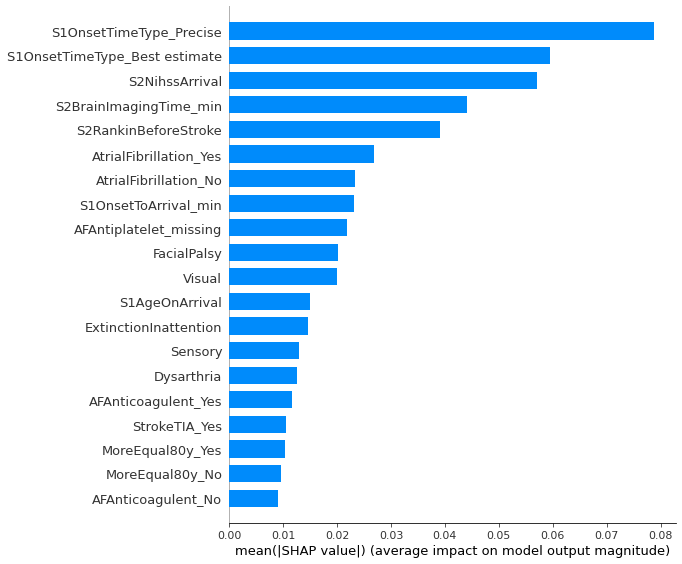

<Figure size 432x288 with 0 Axes>

In [40]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = np.take(shapObj.values, 0, axis=-1), features = dta.values,
                 feature_names = dta.columns.values, plot_type='bar')
plt.tight_layout()

plt.savefig('./output/shap_bar.jpg', dpi=300)

plt.show()

## Observations

Compared with patients where 70% of units would give thrombolysis, those *contentious* patients, where 30-70% of units would give thrombolysis: 

* Are more likely to have an estimated, rather than precise, onset time
* Arrive later
* Have longer arrival to scan times
* Have a lower NIHSS score
* Have greater disability prior to the stroke
* Are older
* Do not have facial palsy
* Do not have visual field deficits
* Have atrial fibrillation